<a href="https://colab.research.google.com/github/Dp20032/Neuromatch_BrainCancer/blob/Dhiren/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)


In [4]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 92% 137M/149M [00:02<00:00, 79.2MB/s]
100% 149M/149M [00:02<00:00, 58.2MB/s]


In [5]:
# @title Download and processing Zenodo data - unneeded, data represented in original dataset
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip

def grab_format_zenodo(type='adnoma', size=(256,256)):
  url = f'https://zenodo.org/record/7047164/files/{type}.zip'
  print(f'Downloading {type}')
  subprocess.call(['wget', '-v', url])
  print(f'{type} acquired, unzipping...')
  subprocess.call(['unzip', '-q', f'{type}.zip'])
  files = os.listdir(f'./{type}')
  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')
  size=(256,256)
  for i in files:
    im = Image.open(f'./{type}/{i}')
    i, _ = i.split('.')
    new = im.resize(size)
    if not os.path.isdir(f'./{type}_png'):
      os.mkdir(f'./{type}_png')
    new.save(f'./{type}_png/{i}.png', 'png')

# for i in ['adnoma', 'Gliomas', 'Meningioma']:
#   grab_format_zenodo(type=i)


In [6]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


In [7]:
classes = os.listdir('./Training/')

0 tensor([0, 1, 0, 1, 0, 2, 2, 1, 1, 0])


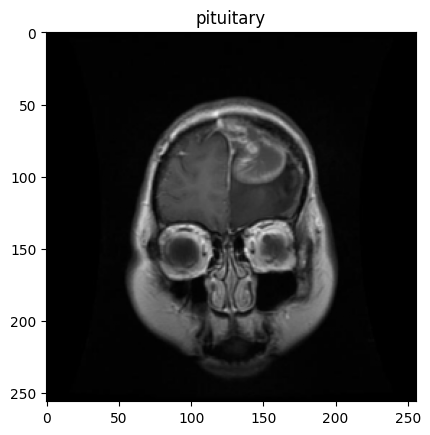

In [8]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])
import matplotlib.pyplot as plt
TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=10, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size=len(ValidationDataset), shuffle=False)

for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [9]:
device= device = torch.device("cuda")

In [ ]:
Classifier = models.vgg19(weights='DEFAULT')

for param in Classifier.features.parameters():
    param.requires_grad = True


#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)

Classifier = Classifier.to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Classifier.parameters(), lr=0.001)



num_epochs = 1

epoch_loss = []
val_loss=[]
val_accuracy=[]

best_loss = np.inf
best_weights = None
patience = 2
no_improvement = 0


for epoch in range(num_epochs):
    train_running_loss = 0.0
    mini_batch_loss= 0.0
    for batch_number, (images, labels) in enumerate(TrainingLoader):

       images = images.to(device)
       labels = labels.to(device)

       optimizer.zero_grad()
       outputs = Classifier(images)
       loss = loss_function(outputs, labels)

       loss.backward()
       optimizer.step()


       train_running_loss += loss.item()
       mini_batch_loss += loss.item()

       if (batch_number + 1) % 10 == 0:
          print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {mini_batch_loss / 50:.3f}')
          mini_batch_loss = 0.0

    epoch_loss.append(train_running_loss / len(TrainingLoader))





    # Validation
    correct = 0
    total = 0
    with torch.no_grad():
        val_running_loss = 0.0
        for images, labels in ValidationLoader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = Classifier(images)

            loss = loss_function(outputs, labels)
            val_running_loss += loss.item()


            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    val_accuracy += [100 * correct / total]
    val_loss += [val_running_loss/len(ValidationLoader)]



    #Early Stopping

    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        best_weights = Classifier.state_dict()
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break


    print(f'Epoch {epoch + 1} Loss: {train_running_loss / len(TrainingLoader):.3f}')
    print(f'Epoch {epoch + 1} Validation Accuracy: {val_accuracy[epoch]:.2f}%')
    print(f'Epoch {epoch + 1} Validation Loss: { val_loss[epoch]:.3f}')

print('Finished Training')

#Best Weights
Classifier.load_state_dict(best_weights)

print('Finished Training')

#Plots
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')
plt.show()

Epoch 1, Batch 10, Loss: 0.381
Epoch 1, Batch 20, Loss: 0.312
